# (02) DOVES—LinPois—0

**Motivation**: Is ```rmax_q = 1.0``` really that bad? Not at all. It is the most logical choice. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Build model + trainer

In [3]:
cfg_vae, cfg_tr = default_configs('DOVES', model_type, 'lin|lin')
cfg_vae['rmax_q'] = 1.0

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'DOVES', 'n_ch': 32, 'n_latents': 512, 'prior_clamp': -2.0, 'prior_log_dist': 'uniform', 'rmax_q': 1.0,
'enc_type': 'lin', 'dec_type': 'lin', 'enc_bias': False, 'dec_bias': False}

Trainer:
{'temp_anneal_portion': 1.0, 'temp_anneal_type': 'exp', 'lr': 0.005, 'batch_size': 1000, 'epochs': 3000, 
'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  262.7 K   |
|     ---     |    ---     |
|    fc_enc   |  131.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-2)_rmax(1)_DOVES_z-512_<lin|lin>
mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)_(2024_05_06,16:10)

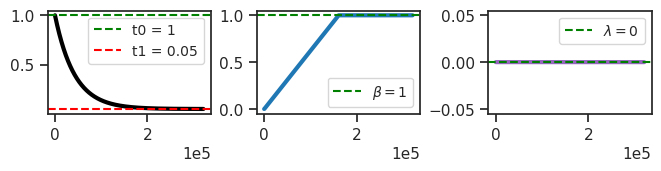

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [5]:
print(vae)

PoissonVAE(
  (mse): MSELoss()
  (fc_enc): Linear(in_features=256, out_features=512, bias=False)
  (fc_dec): Linear(in_features=512, out_features=256, bias=False)
)

In [6]:
vae.fc_dec.bias, vae.fc_enc.bias #.shape

(None, None)

### Train

In [8]:
comment = f"warm{tr.cfg.warm_restart}_{tr.cfg.name()}"
# comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3000, avg loss: 167.684251: 100%|█████████████████████| 3000/3000 [1:19:05<00:00,  1.58s/it]


epoch # 3600, avg loss: 167.117925: 100%|███████████████████████| 3600/3600 [41:31<00:00,  1.44it/s]


### Loss vld (freeze)

In [9]:
data, loss, rates = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 138.16289, 'kl': 29.530691, 'kl_diag': 0.05699688, 'tot': 167.69357}

{'mse': 140.66524, 'kl': 28.776518, 'kl_diag': 0.055483412, 'tot': 169.44176}

{'mse': 136.96426, 'kl': 29.896347, 'kl_diag': 0.057724632, 'tot': 166.86061}

### Identify dead neurons

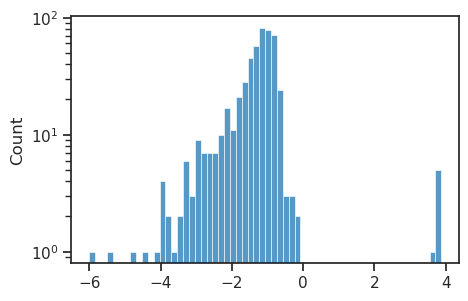

In [34]:
ax = sns.histplot(tonp(vae.log_rate.squeeze()))
ax.set_yscale('log')

In [35]:
dead_thres = 0.006
dead = np.logical_or(
    loss['kl_diag'] < dead_thres,
    tonp(vae.log_rate.squeeze()) > 1.0,
)
dead.sum()

7

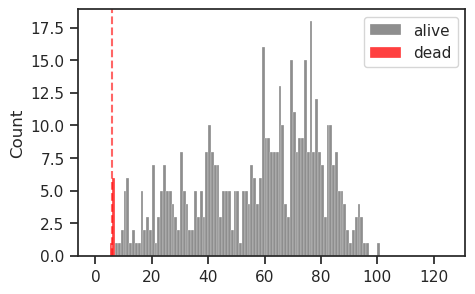

In [36]:
bins = np.linspace(0, 125, 126)
ax = sns.histplot(loss['kl_diag'][~dead] * 1000, bins=bins, color='dimgrey', label='alive')
sns.histplot(loss['kl_diag'][dead] * 1000, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

### Spike counts

In [37]:
lifetime, population, percents = sparse_score(data['z'][:, ~dead], cutoff=0.05)
print(percents)

{'0': 75.6, '1': 19.3, '2': 4.0, '3+': 1.1}

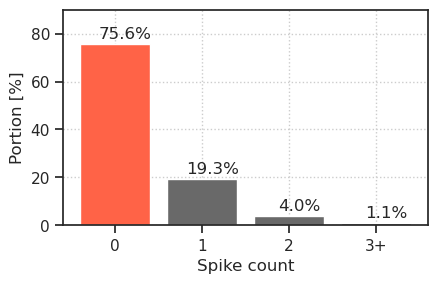

In [38]:
fig, ax = create_figure(1, 1, (4.7, 2.8))

max_val = float(list(percents.values())[0])
ax.set(
    xlabel='Spike count',
    ylabel='Portion [%]',
    ylim=(0, (np.ceil(max_val / 10) + 1) * 10),
)
colors = ['tomato' if lbl == '0' else 'dimgrey' for lbl in percents]
bars = ax.bar(percents.keys(), percents.values(), color=colors)

for bar in bars:
    y = bar.get_height()
    x = bar.get_x() + 1.3 * bar.get_width() / 2
    plt.text(x, y + 1, f'{y:0.1f}%', ha='center', va='bottom')

ax.locator_params(axis='y', nbins=5)

ax.grid()
plt.show()

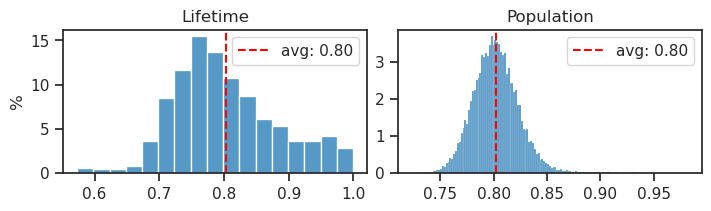

In [39]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(lifetime, stat='percent', ax=axes[0])
sns.histplot(population, stat='percent', ax=axes[1])

for i, x2p in enumerate([lifetime, population]):
    _a, _med = np.nanmean(x2p), np.nanmedian(x2p)
    # axes[i].axvline(_med, color='g', ls='--', label=f'median: {_med:0.2f}')
    axes[i].axvline(_a, color='r', ls='--', label=f'avg: {_a:0.2f}')

add_legend(axes)
axes[0].set(title='Lifetime', ylabel='%')
axes[1].set(title='Population', ylabel='')
plt.show()

In [40]:
tot_nspks = data['z'][:, ~dead].sum(1)
tot_firing = (data['z'][:, ~dead] > 0).mean(1)

min(tot_nspks), max(tot_nspks)

(88.0, 280.0)

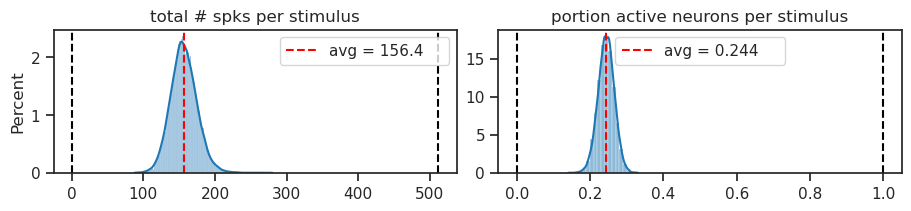

In [41]:
a = np.floor(min(tot_nspks) / 10) * 10
b = np.ceil(max(tot_nspks) / 10) * 10

fig, axes = create_figure(1, 2, (9, 2), layout='constrained')

sns.histplot(tot_nspks, bins=np.linspace(a, b, int(b - a) + 1), kde=True, stat='percent', ax=axes[0])
sns.histplot(tot_firing, bins=np.linspace(0, 1.0, 101), kde=True, stat='percent', ax=axes[1])

_a = tot_nspks.mean()
axes[0].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.1f}    ')
_a = tot_firing.mean()
axes[1].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.3f}    ')

axes[0].axvline(vae.cfg.n_latents, color='k', ls='--')
axes[1].axvline(1.0, color='k', ls='--')

axes[0].set_title('total # spks per stimulus')
axes[1].set(title='portion active neurons per stimulus', ylabel='')

for ax in axes.flat:
    ax.axvline(0, color='k', ls='--')
    ax.legend()
plt.show()

### Cosine sim enc/dec

In [42]:
with torch.inference_mode():
    w_dec = tr.model.fc_dec.weight.detach().data
    w_enc = tr.model.fc_enc.weight.detach().data

    w_dec = w_dec[:, ~dead]
    w_enc = w_enc[~dead]

    cos_sim = F.cosine_similarity(w_dec.T, w_enc)
    slope = torch.einsum('ic, ci -> c', w_dec, w_enc)
    slope /= torch.norm(w_enc, dim=1).pow(2)

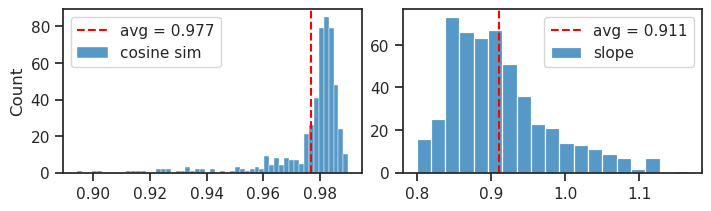

In [43]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(tonp(cos_sim), label='cosine sim', ax=axes[0])
sns.histplot(tonp(slope), label='slope', ax=axes[1])

_avg = cos_sim.mean().item()
axes[0].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')
_avg = slope.mean().item()
axes[1].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')

for ax in axes.flat:
    ax.legend()
axes[1].set_ylabel('')
plt.show()

### Plot enc/dec weights

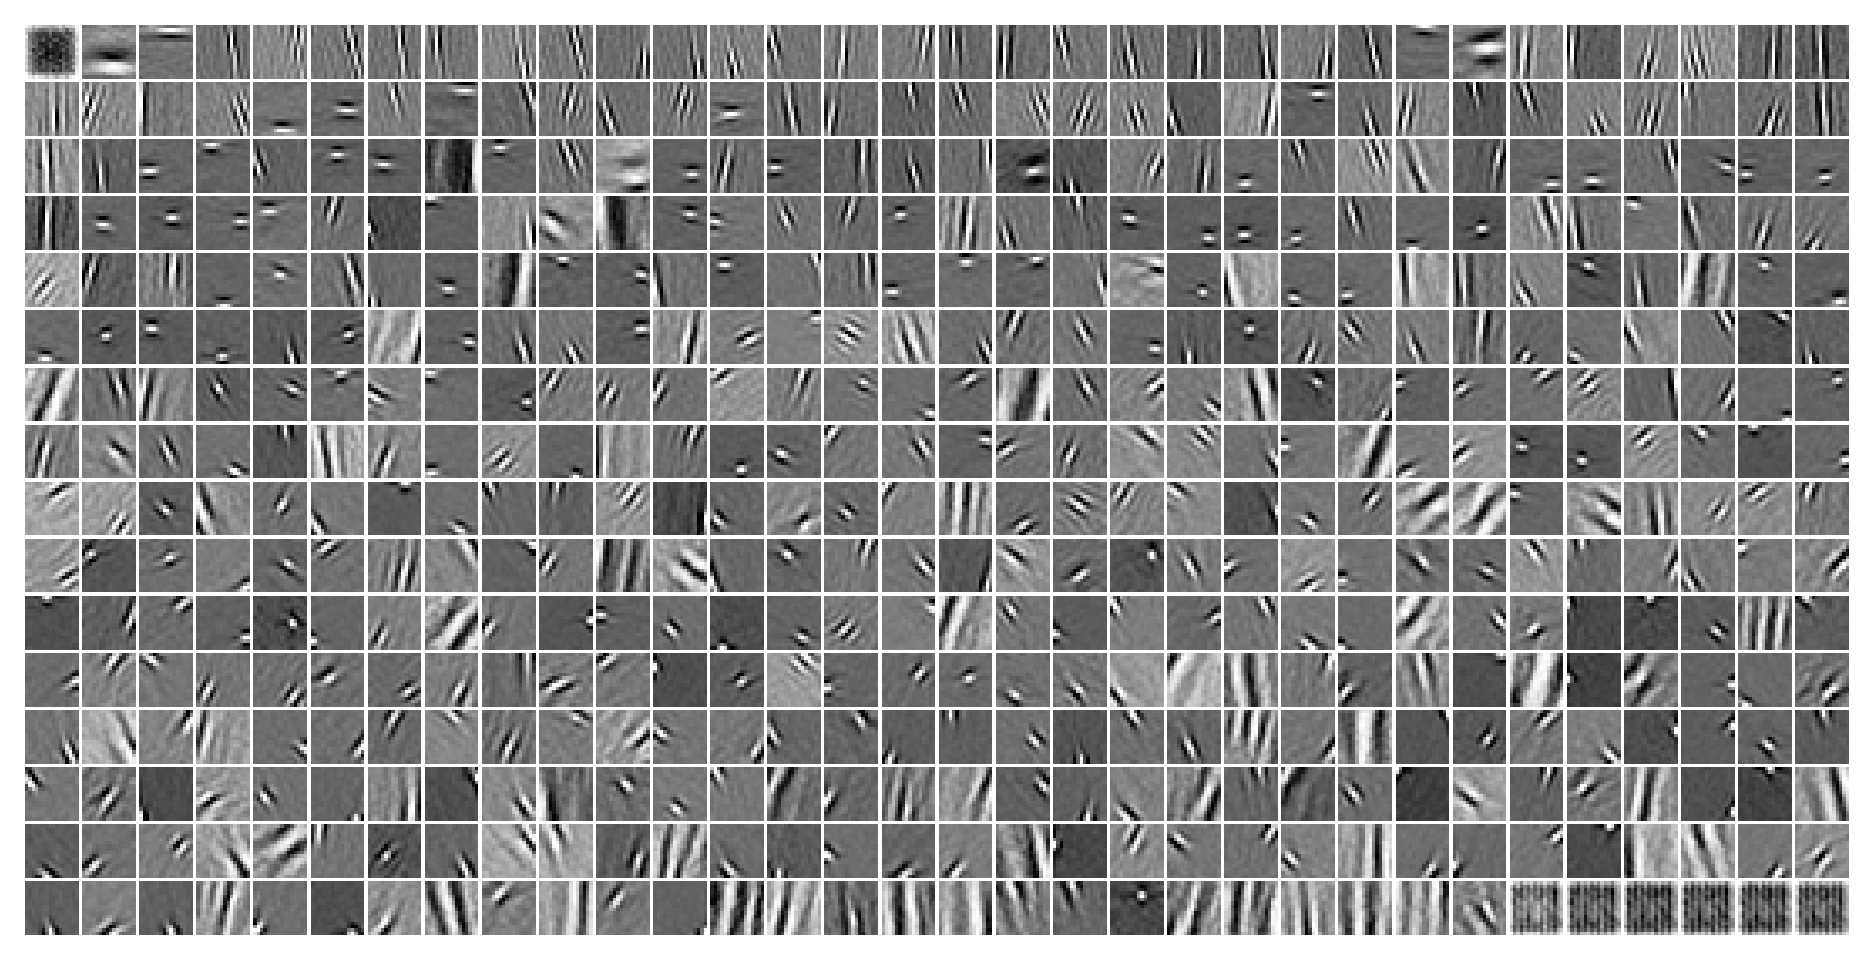

In [44]:
vae.show(dpi=250, order=np.argsort(tonp(vae.log_rate.squeeze())));

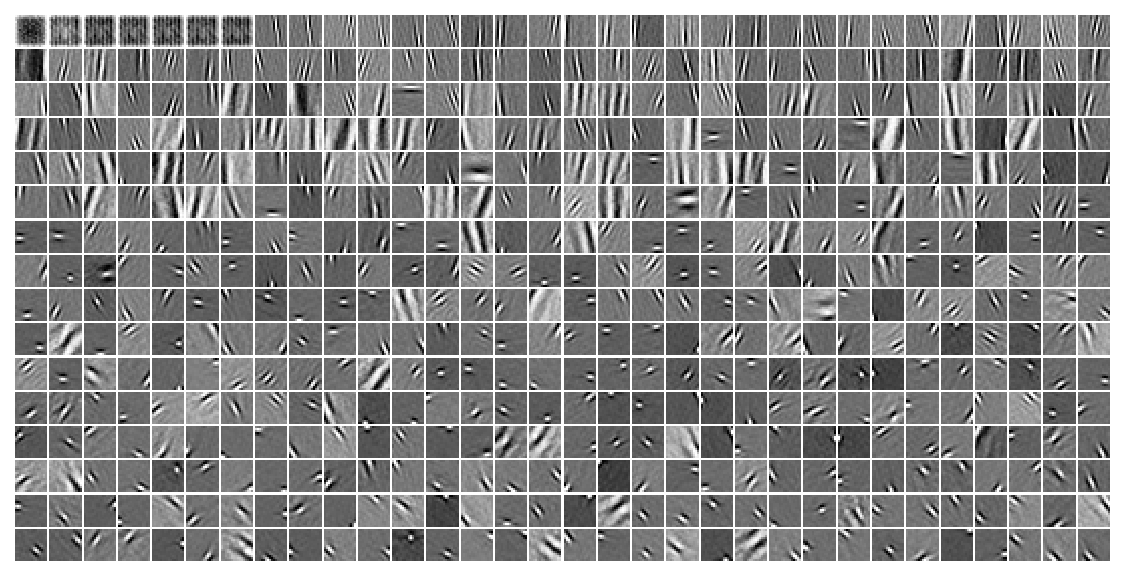

In [45]:
vae.show(dpi=150, order=np.argsort(loss['kl_diag']));

### Some more distributions

In [46]:
tr.model.temp, tr.cfg.kl_beta

(tensor(0.0505, device='cuda:0'), 1.0)

In [47]:
prior_rates = tonp(vae.log_rate)[:, ~dead].ravel()
rv = sp_stats.norm(*sp_stats.norm.fit(prior_rates))
xs = np.linspace(rv.ppf(1e-5), rv.ppf(1 - 1e-5), 1000)
pdf = rv.pdf(xs)

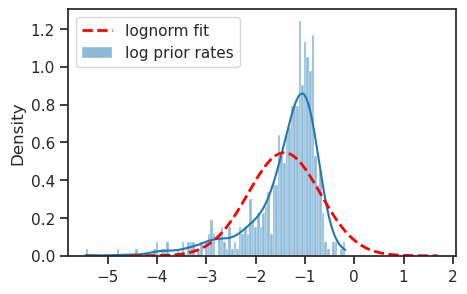

In [48]:
fig, ax = create_figure()

sns.histplot(prior_rates, stat='density', bins=100, kde=True, label='log prior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

In [49]:
ks = sp_stats.kstest(
    rvs=prior_rates,
    cdf=rv.cdf,
    alternative='two-sided',
)
print(ks)

KstestResult(statistic=0.16305181638430571, pvalue=3.366560556854871e-12, statistic_location=-1.5170462, 
statistic_sign=-1)

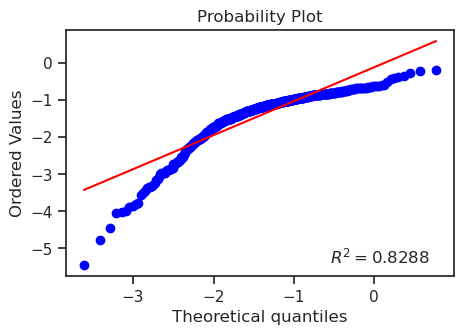

In [50]:
(osm, osr), (slope, intercept, r) = sp_stats.probplot(
    x=prior_rates,
    sparams=rv.args,
    rvalue=True,
    dist='norm',
    plot=plt,
)
plt.show()

In [52]:
posterior_log_rates = np.log(rates['r*dr'][:, ~dead]).ravel()
rv = sp_stats.norm(*sp_stats.norm.fit(posterior_log_rates))
xs = np.linspace(rv.ppf(1e-5), rv.ppf(1 - 1e-5), 1000)
pdf = rv.pdf(xs)

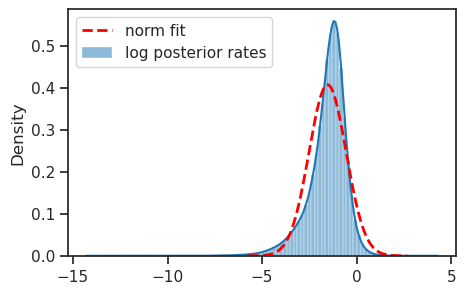

In [53]:
fig, ax = create_figure()

sns.histplot(posterior_log_rates, stat='density', bins=100, kde=True, label='log posterior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='norm fit')
add_legend(ax)
plt.show()

In [54]:
ks = sp_stats.kstest(
    rvs=posterior_log_rates,
    cdf=rv.cdf,
    alternative='two-sided',
)
print(ks)

KstestResult(statistic=0.08881112034764493, pvalue=0.0, statistic_location=-1.7234266, statistic_sign=-1)

In [55]:
vae.log_rate.squeeze()[dead]

tensor([ 3.7837,  3.5549,  3.8150,  3.8781,  3.7890, -6.0048,  3.7645],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [56]:
loss['kl_diag'][dead]

array([0.00647245, 0.00642902, 0.0065402 , 0.00649288, 0.00649661,
       0.00506619, 0.00651657], dtype=float32)

In [58]:
from fitter import Fitter
f = Fitter(np.exp(prior_rates), distributions=['lognorm', 'loggamma'])
f.fit()

2024-05-06 17:43:47.993 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=35.365611)
2024-05-06 17:43:48.014 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted loggamma distribution with error=32.059345)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
loggamma,32.059345,184.422716,197.096391,inf,0.039885,0.387728
lognorm,35.365611,152.404670,165.078346,inf,0.046258,0.223040


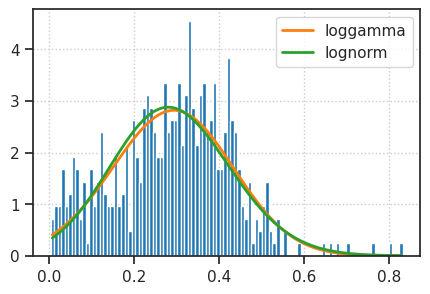

In [59]:
f.summary()